<a href="https://colab.research.google.com/github/lis-r-barreto/Data-Engineering/blob/main/12_Implementing_a_Key_Value_Database.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Implementing an efficient Key-Value Database through tree data structures

In this project, we'll use a [B-tree](https://en.wikipedia.org/wiki/B-tree) data structure as a building block for a fully functioning key-value store.

Trees generally allow elements to have more than one successor. We use the term binary when the number of successors is at most equal to two. In a tree, an element can have more than one successor. We call the elements in a tree __nodes__, and successors are called __children__. We call the top node the __root__ of the tree. Nodes that don't have children (no successors) are called __leaves__. The reason why we call this data structure a tree is that it somewhat resembles an upside-down tree.

B-trees allows us to store key-value pairs like a dictionary. However, they also allow us to perform range searches that dictionaries do not allow. A range search corresponds to a query where we want to retrieve all entries for which the key falls within a given range. Unlike binary trees, B-trees aren't necessarily binary. This means that a node can have more than two children.

A key-value store is a database that operates similar to a Python dictionary. Our key-value store will work like a Python dictionary, but it will also allow users to perform range queries. Our goal will be to create an easy-to-use, flexible, and adaptable key value store that other developers could use in their projects.

There are multiple implementations of the key-value store used in production-grade systems worldwide. Some examples of open-source implementations are Redis, CouchDB, Mongo, and Cassandra (which uses a B-tree as the underlying data structure). 

### 1. Building the necessary structures

#### 1.1 Previous classes: Node

In [ ]:
import bisect

class Node:

    def __init__(self, keys=None, values=None, children=None, parent=None):
        self.keys = keys or []
        self.values = values or []
        self.parent = parent
        self.set_children(children)
        
    def set_children(self, children):
        self.children = children or []
        for child in self.children:
            child.parent = self

    def is_leaf(self):
        return len(self.children) == 0

    def contains_key(self, key):
        return key in self.keys

    def get_value(self, key):
        for i, k in enumerate(self.keys):
            if k == key:
                return self.values[i]
        return None

    def get_insert_index(self, key):
        return bisect.bisect(self.keys, key)

    def insert_entry(self, key, value):
        insert_index = self.get_insert_index(key)
        self.keys.insert(insert_index, key)
        self.values.insert(insert_index, value)
        return insert_index

    def split(self):
        if self.parent is None:
            return self.split_no_parent()
        return self.split_with_parent()

    def split_no_parent(self):
        split_index = len(self) // 2
        key_to_move_up = self.keys[split_index]
        value_to_move_up = self.values[split_index]
        # Create right node
        right_node = Node(self.keys[split_index+1:], self.values[split_index+1:], self.children[split_index+1:])
        # Update left node (self)
        self.keys = self.keys[:split_index]
        self.values = self.values[:split_index]
        self.children = self.children[:split_index+1]
        # Create parent
        parent = Node([key_to_move_up], [value_to_move_up], [self, right_node])
        return parent

    def insert_child(self, insert_index, child):
        self.children.insert(insert_index, child)
        child.parent = self

    def split_with_parent(self):
        split_index = len(self) // 2
        key_to_move_up = self.keys[split_index]
        value_to_move_up = self.values[split_index]
        # Create right node
        right_node = Node(self.keys[split_index+1:], self.values[split_index+1:], self.children[split_index+1:])
        # Update left node (self)
        self.keys = self.keys[:split_index]
        self.values = self.values[:split_index]
        self.children = self.children[:split_index+1]
        # Add new child to parent
        insert_index = self.parent.insert_entry(key_to_move_up, value_to_move_up)
        self.parent.insert_child(insert_index + 1, right_node)
        return self.parent

    def __len__(self):
        return len(self.values)

#### 1.2 Previous classes: B-tree

In [ ]:
class BTree:
    
    def __init__(self, split_threshold):
        self.root = Node()
        self.split_threshold = split_threshold
        self.height = 0
        self.size = 0

    def __len__(self):
        return self.size

    def _find_node(self, current_node, key):
        if current_node.contains_key(key):
            return current_node
        if current_node.is_leaf():
            return None
        child_index = current_node.get_insert_index(key)
        return self._find_node(current_node.children[child_index], key)

    def contains(self, key):
        node = self._find_node(self.root, key)
        if node is None:
            return False
        return True

    def _add(self, current_node, key, value):
        if current_node.is_leaf():
            current_node.insert_entry(key, value)
        else:
            child_index = current_node.get_insert_index(key)
            self._add(current_node.children[child_index], key, value)
        if len(current_node) > self.split_threshold:
            parent = current_node.split()
            if current_node == self.root:
                self.root = parent
                self.height += 1

    def add(self, key, value):
        self._add(self.root, key, value)
        self.size += 1

    def get_value(self, key):
        node = self._find_node(self.root, key)
        if node is None:
            return None
        return node.get_value(key)

#### 1.3 Main class: KVStore

In [ ]:
class KVStore(BTree):
    
    def __init__(self):
        super().__init__(split_threshold=2)
        
    def add(self, key, value):
        node = self._find_node(self.root, key)
        if node is None:
            super().add(key, value)
        else:
            for i, k in enumerate(node.keys):
                if key == k:
                    node.values[i] = value
                    
    def __getitem__(self, key):
        return self.get_value(key)
    
    def __setitem__(self, key, value):
        return self.add(key, value)
    
    def __contains__(self, key):
        return self.contains(key)
    
    def _range_query(self, range_start, range_end, current_node, min_key, max_key):
        if range_start > max_key or range_end < min_key:
            return []
        results = []
        for i, key in enumerate(current_node.keys):
            if range_start <= key and key <= range_end:
                results.append(current_node.values[i])
        if not current_node.is_leaf():
            for i, child in enumerate(current_node.children):
                new_min_key = current_node.keys[i - 1] if i > 0 else min_key
                new_max_key = current_node.keys[i] if i < len(current_node) else max_key
                results += self._range_query(range_start, range_end, child, new_min_key, new_max_key)
        return results 

    def range_query(self, range_start, range_end):
        return self._range_query(range_start, range_end, self.root, float('-inf'), float('inf'))

### 2. Testing the implementation

First, let's ensure that we can add values to the KVStore and that if we use repeated keys, the values get replaced.

In [ ]:
kv = KVStore()
kv.add(1, 'hello')
kv.add(2, 'world')

assert kv.split_threshold == 2, "The split is not equal to 2"
assert kv.get_value(1) == 'hello', "Wrong test 1"
assert kv.get_value(2) == 'world', "Wrong test 2"

kv.add(1, 'goodbye')

assert kv.get_value(1) == 'goodbye', "Wrong test 3"

By now, we know that we can use the key-value store to add entries and retrieve values.

We have made KVStore easier to use by allowing users to use the bracket syntax to add entries and retrieve values. Let's check this behaviour.

In [ ]:
kv[3] = 'this'
kv[4] = 'is'

assert 'this' == kv[3], "Wrong test 4"
assert 'is' == kv[4], "Wrong test 5"

kv[3] = 'and'

assert 'and' == kv[3], "Wrong test 6"

Another nice feature of the dictionary to have is the ability to use the in operator to check whether a given key is stored. We have performed this implementation and we will check it.

In [ ]:
assert 1 in kv, "Wrong test 7"

So far, we've implemented and checked the same functionality as a dictionary. Now it is time to make it more powerful by implementing range queries. Let's check this implementation.

In [ ]:
assert kv.range_query(2, 4) == ['world', 'and', 'is'], "Wrong test 8"

When we're dealing with new data structures, one way to test them is to compare them with a simpler implementation that we know is correct. We perform the same operations on both and see if both provide the same results.

Here below is an implementation of a key-value store that uses a dictionary as the base data structure. We will use it to test the implementation of the new structure.

In [ ]:
class DictKVStore(dict):

    def range_query(self, range_start, range_end):
        result = []
        for key in self.keys():
            if range_start <= key and key <= range_end:
                result.append(self[key])
        return result

In [ ]:
import random

def generate_randoms(start_range, end_range, samples):
    try:
        return random.sample(range(start_range, end_range), samples)
    except ValueError:
        print('Sample size exceeded population size.')
    

    
dict_kv = DictKVStore()
custom_kv = KVStore()
random_values = generate_randoms(1, 100, 10)

for i in random_values:
    dict_kv[i] = i
    custom_kv[i] = i

for range_start, range_end in [(1, 15), (32, 58), (62, 85), (90, 100)]:
    dict_res = sorted(dict_kv.range_query(range_start, range_end))
    custom_res = sorted(custom_kv.range_query(range_start, range_end))
    assert dict_res == custom_res, "Both data structures does not return the same range query result."

Note that when we compare the result of a range query, we need to sort the values beforehand because the data structures can return the values in a different order.

### 3. Performance testing

The main reason to implement a new data structure to perform these operations having a much simpler implementation (Python dictionary) is the performance of range queries. 

While there are several ways to compare the performance of both data structures, we will follow these steps:

- Generate many entries (about 50,000 should be enough).
- Generate many query intervals. It's better to generate in a way that increases the number of query results from 1 to some given value. This way, we can see the impact of the number of results in the performance gained.
- For each query, compute the ratio between the runtime using the dictionary-based implementation and the B-tree-based implementation. A ratio of 1 means that both took the same time, a ratio of 2 means that the B-tree implementation was two times faster, and so on.
- Plot the runtime ratios to better visualize the results.


In [ ]:
import time

dict_kv = DictKVStore()
custom_kv = KVStore()
random_entries_keys = generate_randoms(1, 99999, 50000)
random_entries_values = generate_randoms(1, 99999, 50000)

for k, v in zip(random_entries_keys, random_entries_values):
    dict_kv[k] = v
    custom_kv[k] = v

random_queries = generate_randoms(1, 99999, 1000)
rand_queries = []

for i in range(1000):
    start_range = random_queries[i]
    end_range = random_queries[i] + i
    rand_queries.append((start_range, end_range))

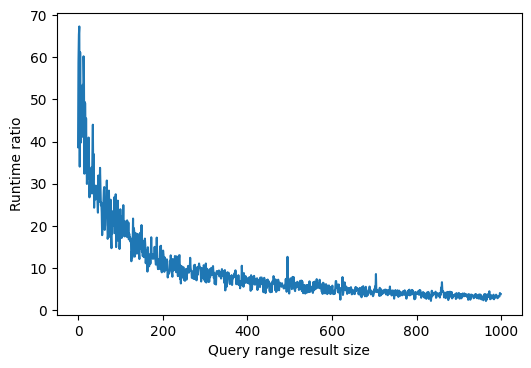

In [ ]:
time_ratios = []

for range_start, range_end in rand_queries:
    start = time.time()
    dict_res = dict_kv.range_query(range_start, range_end)
    end = time.time()
    runtime_dict = end - start
    
    start = time.time()
    custom_res = custom_kv.range_query(range_start, range_end)
    end = time.time()
    runtime_res = end - start
    
    runtime = runtime_dict / runtime_res
    time_ratios.append(runtime)
    
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(time_ratios)
plt.xlabel('Query range result size')
plt.ylabel('Runtime ratio')
plt.show()

Analysing the results obtained, it can be seen that the new data structure is much faster than the standard Python dictionary implementation in obtaining results through a query. This speed is much more significant for small query ranges, while, as the ranges increase, the response times of both approaches converge.